(a) The parameters of Gaussian Mixture Model (GMM) can be estimated via the EM algorithm. Show that the alternating algorithm for K-means is a special case of the EM algorithm and show the corresponding objective functions for E-step and M-step.

(b) Download the Old Faithful Geyser Dataset. The data file contains 272 observations of (eruption time, waiting time). Treat each entry as a 2 dimensional feature vector. Parse and plot all data points on 2-D plane.

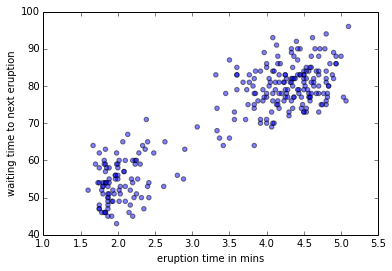

In [70]:
# Old Faithful Geyser Data

# Description: (From R manual):

#      Waiting time between eruptions and the duration of the eruption
#      for the Old Faithful geyser in Yellowstone National Park, Wyoming,
#      USA.

#      A data frame with 272 observations on 2 variables.

# eruptions  numeric  Eruption time in mins
# waiting    numeric  Waiting time to next eruption
# 
# Data converted to csv for convenience..

import numpy as np
import csv
with open('data/faithful.csv', 'rb') as f:
    reader = csv.reader(f)
    your_list = list(reader)

data = np.array(your_list).astype(np.float)

# Displaying all the points on 2D plane
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(data[:,0], data[:,1], alpha=0.5)
plt.xlabel('eruption time in mins')
plt.ylabel('waiting time to next eruption')
plt.show()



(c) Implement a bimodal GMM model to fit all data points using EM algorithm. Explain the reasoning behind your termination criteria. For this problem, we assume the covariance matrix is spherical (i.e., it has the form of σ^2I) and you can randomly initialize Gaussian parameters.
For evaluation purposes, please submit the following figures:

• Plot the trajectories of two mean vectors in 2 dimensions (i.e., coordinates vs. iteration).

• Run your program for 50 times with different initial parameter guesses. Show the distribution
of the total number of iterations needed for algorithm to converge.

In [71]:
import random as rd

def random_parameters(data, K):
    cols = (data.shape)[1]
     
    # Random assignment of mu's between 0 and 1
    mu = np.zeros((K, cols))
    for k in range(K):
        for l in range(cols):
            mu[k][l]=rd.random()   
    
    # Sigma values are calculated by selecting a random subset of 
    # data array and taking the covariance of it
    sigma = []
    for k in range(2):
        sigma.append(np.cov(data[:20+int(rd.random()*(len(data)-20))].T))
    
    # pi is a random array of size 2 summing up to 1
    pi = np.zeros(2)
    pi[0] = rd.random()
    pi[1] = 1- pi[0]

    return mu, sigma, pi




This is what we are going to implement 
<img src="data/emalgorithm.png">

In [72]:
def gaussian(x, mu, sigma):
    dim = len(x)
    norm_factor = (2*np.pi)**dim

    norm_factor *= np.linalg.det(sigma)
    norm_factor = 1.0/np.sqrt(norm_factor)

    x_mu = np.matrix(x-mu)

    rs = norm_factor*np.exp(-0.5*x_mu*np.linalg.inv(sigma)*x_mu.T)
    return rs

In [76]:
def e_step(data, K, mu, sigma, pi):   
    sample_size = (data.shape)[0]
 
    resp = np.zeros((sample_size, K))
 
    for i in range(sample_size):
        likelihood = ((pi[0]*gaussian(data[i], mu[0], sigma[0])) + ((1-pi[0])*gaussian(data[i], mu[1], sigma[1]))) 
        resp[i][0] = pi[0]*gaussian(data[i], mu[0], sigma[0])/likelihood
        resp[i][1] = pi[1]*gaussian(data[i], mu[1], sigma[1])/likelihood
    
    return resp

In [77]:
def m_step(data, K, resp):
    sample_size = (data.shape)[0]
    cols = (data.shape)[1]
    
    mu = np.zeros((K, cols))
    sigma = np.zeros((K, cols, cols))
    pi = np.zeros(K)

    marg_resp = np.zeros(K)
    for k in range(K):
        for i in range(sample_size):
            marg_resp[k] += resp[i][k]
            mu[k] += (resp[i][k])*data[i]
        mu[k] /= marg_resp[k]

        for i in range(sample_size):
            x_mu = np.zeros((1,cols))+data[i]-mu[k]
            sigma[k] += (resp[i][k]/marg_resp[k])*x_mu*x_mu.T

        pi[k] = marg_resp[k]/sample_size        
        
    return mu, sigma, pi

In [78]:
# First let's scale data to a range
from sklearn import preprocessing
import numpy as np
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(data)

# Randomize our gaussian variables
mu,sigma,pi = random_parameters(data_scaled,2)

# Run it 50 times to see the mu trajectory
mu_trajectory = []
iteration = []
mu_trajectory.append(mu)
for i in range(50):
    resp = e_step(data_scaled,2,mu,sigma,pi)
    mu,sigma,pi = m_step(data_scaled,2,resp)
    iteration.append(i)
    mu_trajectory.append(mu)

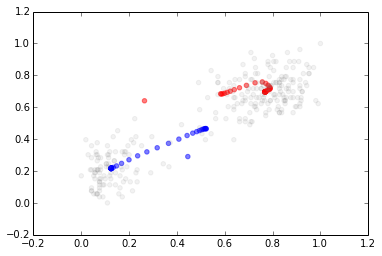

In [79]:
# Displaying all the points on 2D plane
%matplotlib inline
import matplotlib.pyplot as plt

mu_trajectory = np.array(mu_trajectory)


plt.scatter(mu_trajectory[:,0,0],mu_trajectory[:,0,1], alpha=0.5, color='red')
plt.scatter(mu_trajectory[:,1,0],mu_trajectory[:,1,1], alpha=0.5, color='blue')
plt.scatter(data_scaled[:,0], data_scaled[:,1], alpha=0.1,color='grey')
plt.show()


Run your program for 50 times with different initial parameter guesses. Show the distribution
of the total number of iterations needed for algorithm to converge.

In [80]:
numberOfIterations = []

for k in range(50):
    mu,sigma,pi = random_parameters(data_scaled,2)
    mu_trajectory = []
    mu_trajectory.append(mu)
    for i in range(250): # this is another stopping criteria
        resp = e_step(data_scaled,2,mu,sigma,pi)
        mu,sigma,pi = m_step(data_scaled,2,resp)
        iteration.append(i)
        mu_trajectory.append(mu)
        
        # I put 0.00001 difference between the last and current sum of mu's
        # because if the difference is lower than this, there is no need to
        # progress further
        if np.abs(np.sum(mu_trajectory[-1]-mu_trajectory[-2])) < 0.00001:
            numberOfIterations.append(i)
            break

print numberOfIterations

[17, 24, 166, 32, 28, 23, 25, 21, 15, 26, 22, 24, 17, 18, 18, 24, 14, 32, 14, 41, 91, 21, 26, 27, 26, 41, 33, 106, 49, 21, 41, 14, 30, 15, 30, 20, 35, 35, 30, 27, 34, 30, 32, 25, 34, 43, 41, 163, 35, 44]


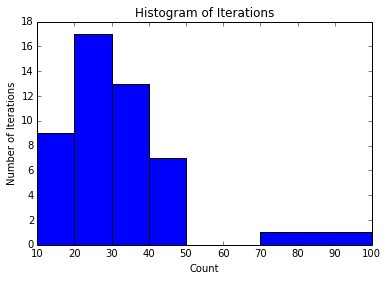

In [81]:
import matplotlib.pyplot as plt
plt.hist(numberOfIterations,bins=[0, 10, 20, 30, 40, 50,60,70,100])
plt.xlabel('Count')
plt.ylabel('Number of Iterations')
plt.title(r'Histogram of Iterations')


(d) Repeat the task in (c) but with the initial guesses of the parameters generated from the following
process:

• Run a K-means algorithm over all the data points with K = 2 and label each point with one of the two clusters.

• Estimate the first guess of the mean and covariance matrices using maximum likelihood over the labeled data points.

Compare the algorithm performances of (c) and (d).

In [82]:
from sklearn import cluster, datasets

def kmeans_parameters(data):
    k_means = cluster.KMeans(n_clusters=2)
    k_means.fit(data) 

    cluster1 = []
    cluster2 = []
    for i in range(len(data)):
        if k_means.labels_[i] == 0:
            cluster1.append(data[i])
        if k_means.labels_[i] == 1:
            cluster2.append(data[i])

    cluster1 = np.array(cluster1)
    cluster2 = np.array(cluster2)

    def findMuMLE(clusterData):
        summation = 0
        for i in range(len(clusterData)):
            summation += clusterData[i]
        return summation/len(clusterData)

    def findSigmaMLE(clusterData,mu):
        covariance_matrix = np.zeros((2,2))
        for i in range(len(clusterData)):
            covariance_matrix += (clusterData[i]-mu).reshape(2,1).dot((clusterData[i]-mu).reshape(2,1).T)
        return covariance_matrix/len(clusterData)


    mu = np.array([findMuMLE(cluster1),findMuMLE(cluster2)])
    sigma  =[np.sqrt(findSigmaMLE(cluster1,mu[0])),np.sqrt(findSigmaMLE(cluster2,mu[0]))]
    
    return mu,sigma,[0.5,0.5]


In [83]:
mu,sigma,pi = kmeans_parameters(data_scaled)

mu_trajectory = []
iteration = []
mu_trajectory.append(mu)
for i in range(50):
    resp = e_step(data_scaled,2,mu,sigma,pi)
    mu,sigma,pi = m_step(data_scaled,2,resp)
    iteration.append(i)
    mu_trajectory.append(mu)
        

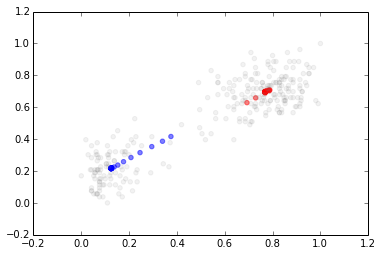

In [84]:
# Displaying all the points on 2D plane
%matplotlib inline
import matplotlib.pyplot as plt

mu_trajectory = np.array(mu_trajectory)


plt.scatter(mu_trajectory[:,0,0],mu_trajectory[:,0,1], alpha=0.5, color='red')
plt.scatter(mu_trajectory[:,1,0],mu_trajectory[:,1,1], alpha=0.5, color='blue')
plt.scatter(data_scaled[:,0], data_scaled[:,1], alpha=0.1,color='grey')
plt.show()


In [88]:
numberOfIterations = []

for k in range(50):
    mu,sigma,pi = kmeans_parameters(data)
    mu_trajectory = []
    mu_trajectory.append(mu)
    for i in range(250):
        resp = e_step(data,2,mu,sigma,pi)
        mu,sigma,pi = m_step(data,2,resp)
        iteration.append(i)
        mu_trajectory.append(mu)

        if np.abs(np.sum(mu_trajectory[-1]-mu_trajectory[-2])) < 0.00001:
            numberOfIterations.append(i)
            break

print numberOfIterations

[10, 10, 10, 10, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 12, 12, 10, 10, 10, 12, 12, 10, 12, 10, 12, 10, 10, 12, 12, 10, 10, 10, 10, 12, 10, 10, 10, 12, 12, 12, 12, 10, 12, 10, 12]


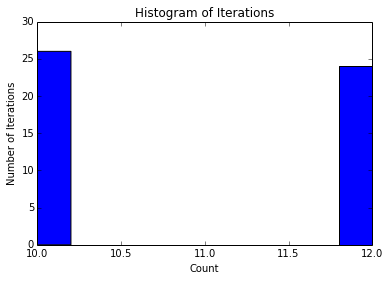

In [86]:
import matplotlib.pyplot as plt
plt.hist(numberOfIterations)
plt.xlabel('Count')
plt.ylabel('Number of Iterations')
plt.title(r'Histogram of Iterations')
